<a href="https://colab.research.google.com/github/victwise/fastai_numerical_linear_algebra/blob/master/Cap%C3%ADtulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resources:


*   Main: http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb
*   Norms: https://machinelearningmastery.com/vector-norms-machine-learning/
*  SGD: https://machinelearningmastery.com/gradient-descent-for-machine-learning/



In [19]:
! pip install ipywidgets
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig i965-va-driver libaacs0 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2 libbs2b0
  libcaca0 libcairo2 libcdio-cdda2 libcdio-paranoia2 libcdio17 libchromaprint1
  libcroco3 libcrystalhd3 libdatrie1 libdc1394-22 libdrm-amdgpu1 libdrm-intel1
  libdrm-nouveau2 libdrm-radeon1 libfftw3-double3 libflac8 libflite1
  libfribidi0 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libgl1 libgl1-mesa-dri libglx-mesa0 libglx0 libgme0 libgsm1 libiec61883-0
  libjack-jackd2-0 libjbig0 libllvm6.0 libmp3lame0 libmpg123-0 libmysofa0
  libnuma1 libogg0 libopenal-data libopenal1 libopenjp2-7 libopenmpt0 libopus0
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpciaccess0
  libpixman-1-0 libpostproc54 libpu

In [23]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59910000 @  0x7f782d2e52a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


# Modelando con NMF y SVD

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

Configurando Datos

In [30]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [31]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [32]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [33]:
newsgroups_train.target

array([1, 3, 2, ..., 1, 0, 1])

In [34]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space', ..., 'comp.graphics', 'alt.atheism',
       'comp.graphics'], dtype='<U18')

In [35]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [0]:
num_topics, num_top_words = 6, 8

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [38]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [39]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [0]:
vocab = np.array(vectorizer.get_feature_names())

In [41]:
vocab.shape

(26576,)

In [42]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar', 'costing', 'costly',
       'costruction', 'costs', 'cosy', 'cote', 'couched', 'couldn', 'council', 'councils',
       'counsel', 'counselees', 'counselor', 'count'], dtype='<U80')

#Descomposición de Valor Singular (SVD)

In [43]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 39s, sys: 6.14 s, total: 1min 45s
Wall time: 54.3 s


In [44]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


### Ejercicio: confirma que U, s, Vh es una descomposición de las variables 

In [45]:
#Obteniendo o creando la diagonal de un vector - np.diag
#np.diag te permite obtener una matriz de un vector, o un vector de una matriz
reconstruyendo_vector = U @ np.diag(s) @  Vh
np.linalg.norm(reconstruyendo_vector - vectors)
np.allclose(reconstruyendo_vector,vectors)

True

###Ejercicio: confirme que U, Vh son ortonormales

In [46]:
#Ortogonales:Multiplicación de sus transposiciones y luego su comparación con su identidad
#np.eye - Devuelve una matriz que tiene 1 en la diagonal y 0 en cualquier otra parte de la matriz
np.allclose(U @ U.T, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

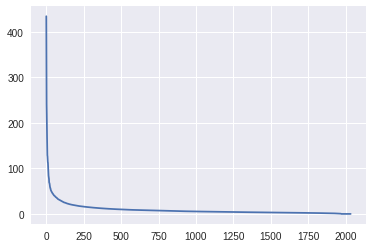

In [47]:
plt.plot(s)

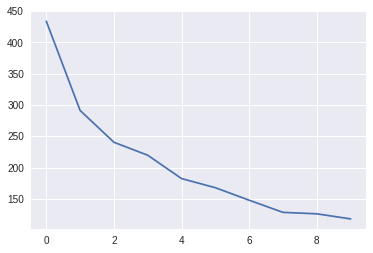

In [48]:
plt.plot(s[:10])

In [0]:
#np.argsort - Devuelve los índices que clasificarían una matriz.
#El método join () proporciona una forma flexible de concatenar strings. 
#Concatena cada elemento de forma iterable (como listas, strings y tuplas) y devuelve el string concatenado.


num_top_words=8


def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [50]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

# Factorización matricial no negativa (NMF)

La factorización de matriz no negativa (FNM) es una factorización no exacta que se basa en una matriz positiva delgada y una matriz positiva corta. NMF es NP-hard y no único. Hay una serie de variaciones en NMF, creadas agregando diferentes restricciones.

In [0]:
n,m=vectors.shape
d=5 #num topics

In [0]:
CLF = decomposition.NMF(n_components=d,random_state=1)

W1 = CLF.fit_transform(vectors)
H1 = CLF.components_

In [53]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

###TF_IDF
La frecuencia de documentos de frecuencia inversa (TF-IDF, por sus siglas en inglés) es una forma de normalizar el recuento de términos teniendo en cuenta la frecuencia con la que aparecen en un documento, la duración del documento y el carácter común/raro del término.

TF = (# recuento del término t en el documento) / (# de palabras en el documento)

IDF = log(# de documentos / # de documentos con el término t en el documento)

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) #(documents,vocab)

In [0]:
W1 = CLF.fit_transform(vectors_tfidf)
H1 = CLF.components_

In [56]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

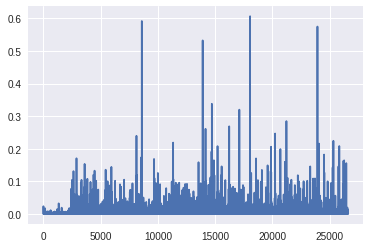

In [57]:
plt.plot(CLF.components_[0])

In [58]:
CLF.reconstruction_err_

43.7129

##NMF usando SGD(Gradiente Estocastica Descendiente)

La idea clave de la pendiente de gradiente estándar :

1. Elige aleatoriamente algunos pesos para comenzar.
2. Loop:
      * Usa pesos para calcular una predicción
      * Calcular la derivada de la pérdida.
      * Actualizar los pesos.

3. Repita el paso 2 muchas veces. Finalmente se termina con algunos pesos decentes.

Clave : Queremos disminuir nuestra pérdida y el derivado nos dice la dirección del descenso más pronunciado .

Tenga en cuenta que la pérdida , el error y el costo son términos usados ​**​para describir lo mismo.**

In [0]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.random import random
from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)

In [0]:
#Función lineal
def lin(a,b,x): return a*x+b

In [0]:
#definiendo los pesos
a=3.
b=8.

In [0]:
n=30
x = random(n)
y = lin(a,b,x)

In [8]:
x

array([0.656 , 0.3872, 0.5473, 0.5352, 0.1011, 0.1615, 0.8352, 0.3188, 0.0265, 0.3819, 0.7293,
       0.8587, 0.8376, 0.9553, 0.2918, 0.2562, 0.7627, 0.5206, 0.2977, 0.4708, 0.2386, 0.3724,
       0.995 , 0.0423, 0.9698, 0.1335, 0.694 , 0.2815, 0.8883, 0.8084])

In [9]:
y

array([ 9.9679,  9.1615,  9.642 ,  9.6056,  8.3034,  8.4845, 10.5055,  8.9563,  8.0796,  9.1457,
       10.188 , 10.576 , 10.5127, 10.866 ,  8.8755,  8.7687, 10.2881,  9.5617,  8.8931,  9.4123,
        8.7159,  9.1173, 10.985 ,  8.1268, 10.9095,  8.4004, 10.0821,  8.8445, 10.6648, 10.4251])

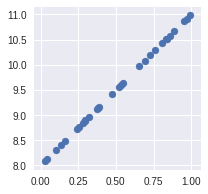

In [10]:
#Cálculo de la dispersión entre puntos
plt.scatter(x,y)

In [0]:
# sse --> sesgo
# loss --> peso
# avg_loss --> promedio de perdidad
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)

In [13]:
#actualizacion de los pesos 
a_guess=-1.
b_guess=1.
avg_loss(y, a_guess, b_guess, x)

9.1247

In [0]:
lr=0.01
# d[(y-(a*x+b))**2,b] = 2 (b + a x - y)      = 2 (y_pred - y)
# d[(y-(a*x+b))**2,a] = 2 x (b + a x - y)    = x * dy/db


In [0]:
#funcion global para actualizar los pesos
def upd():
    global a_guess, b_guess
    
    # hace la predicción usando los pesos actuales
    y_pred = lin(a_guess, b_guess, x)
    
    # calula la derivada de la perdida
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    
    # actuliza los pesos moviendolos en una dirección empinada descendiente 
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

# Pendiente de gradiente estocástico (SGD)

 Es un método de optimización útil (también es el corazón del aprendizaje profundo, donde se utiliza para back-propagation).
 
Para el gradiente estándar descendiente , evaluamos la pérdida utilizando todos nuestros datos, que pueden ser realmente lentos. En la gradiente estocástica descendiente, evaluamos nuestra función de pérdida solo en una muestra de nuestros datos (a veces se denomina mini-lote ). Obteniendo diferentes valores de pérdida en diferentes muestras de los datos, por lo que es estocástico . Resulta que esta sigue siendo una forma efectiva de optimizar, ¡y es mucho más eficiente!.


In [25]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

NameError: ignored

In [0]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_


In [0]:
show_topics(H1)

In [0]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [0]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))


In [0]:
def upd(M, W, H, lr):
  dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [0]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [0]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [0]:
report(vectors_tfidf, W, H)

In [0]:
upd(vectors_tfidf,W,H,lr)

In [0]:
report(vectors_tfidf, W, H)

In [0]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

In [0]:
show_topics(H)

# Pytorch

Es un paquete basado en scientific computing package con el objetivo de:
  * Como reemplazo de Numpy para usar el poder del GPU.
  * Como plataforma de investigación de Deep Learning, que posee una máxima flexibilidad y velocidad.

In [0]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [0]:
def V(M): return Variable(M, requires_grad=True)


In [0]:
v=vectors_tfidf.todense()

In [0]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [0]:
mu = 1e-5

In [0]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(tc.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [0]:
t_W = tc.FloatTensor(m,d)
t_H = tc.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [0]:
d=6; lam=100; lr=0.05

In [0]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9